<h1 style="text-align:center; font-size:30px;">A model that estimates the value of players based on their skills, physical characteristics and recognition.</h1>
<p style="text-align:center">The data used in the model come from kaggle.com - https://www.kaggle.com/karangadiya/fifa19</p>
<h3 style="text-align:center">The model aims to provide information for football agents and managers of football clubs that will allow them to negotiate more adequate amounts of transfers.</h3>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<h2>A glance at the data</h2>

In [2]:
footballers = pd.read_csv('fifa19.csv')

<b>The data set consists of 89 columns of data. However, most of them are meaningless and do not apply when predicting the value of a player. Therefore, in a moment some of them will be removed.</b>

In [3]:
footballers.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [4]:
footballers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
Unnamed: 0                  18207 non-null int64
ID                          18207 non-null int64
Name                        18207 non-null object
Age                         18207 non-null int64
Photo                       18207 non-null object
Nationality                 18207 non-null object
Flag                        18207 non-null object
Overall                     18207 non-null int64
Potential                   18207 non-null int64
Club                        17966 non-null object
Club Logo                   18207 non-null object
Value                       18207 non-null object
Wage                        18207 non-null object
Special                     18207 non-null int64
Preferred Foot              18159 non-null object
International Reputation    18159 non-null float64
Weak Foot                   18159 non-null float64
Skill Moves                 18159 non-null fl

<b>In the case of goalkeepers, other qualities (e.g. Diving or Handling) count than those from field players. Therefore, in this model I will only predict the value of players from the field. All Goalkeepers are deleted from the list, because their presence would distort the data.</b> 

In [5]:
footballers.drop(footballers[footballers["Position"]=="GK"].index, inplace=True)

<b>I delete data that does not matter when assessing a player's value, are not quantifiable or would complicate the model too much.</b>

In [6]:
delate_data = ['Unnamed: 0','ID','Name','Photo','Nationality','Flag','Club','Club Logo','Real Face',
               'Jersey Number','Joined','Contract Valid Until','Loaned From','LS','ST','RS','LW','LF','CF',
               'RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB',
               'CB','RCB','RB','GKDiving','GKHandling','GKKicking','GKPositioning','GKReflexes','Release Clause']

In [7]:
footballers.drop(delate_data, axis=1, inplace=True)

<b>Other data seem (at least for now) to matter for our model. However, some of them are text format, so I need to convert them to numbers to be able to use them in the learning algorithm.</b>

In [8]:
footballers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16182 entries, 0 to 18206
Data columns (total 44 columns):
Age                         16182 non-null int64
Overall                     16182 non-null int64
Potential                   16182 non-null int64
Value                       16182 non-null object
Wage                        16182 non-null object
Special                     16182 non-null int64
Preferred Foot              16134 non-null object
International Reputation    16134 non-null float64
Weak Foot                   16134 non-null float64
Skill Moves                 16134 non-null float64
Work Rate                   16134 non-null object
Body Type                   16134 non-null object
Position                    16122 non-null object
Height                      16134 non-null object
Weight                      16134 non-null object
Crossing                    16134 non-null float64
Finishing                   16134 non-null float64
HeadingAccuracy             16134 non-nu

<h2>Data cleaning and transformation</h2>

<b>The value of a player is information that our model is supposed to estimate. Currently, the player's value is a text type variable. I can't pass textual data to the machine learning algorithm so I make the appropriate transformations to get data in numeric format. </b>

In [9]:
footballers["Value"].head()

0    €110.5M
1       €77M
2    €118.5M
4      €102M
5       €93M
Name: Value, dtype: object

<b>At the beginning I clear the data by deleting all 216 players whose value is equal to 0€. Such data could cause unwanted anomalies.</b>

In [10]:
len(footballers[footballers["Value"]=="€0"])

216

In [11]:
footballers.drop(footballers[footballers["Value"]=="€0"].index, inplace=True)

<b>I reset the index because after removing goalkeepers and players worth 0 € the index has become non-continuous.</b>

In [12]:
footballers.set_index("Age", inplace=True) # I temporarily change the index to the age column

In [13]:
footballers.reset_index(inplace=True)  # then I reset the index so a new default is assigned

<b>A function that changes data from the 'Value' column to the float type.</b>

In [14]:
def change_from_str_to_number_value(value_str):
    if value_str[-1] == "M":
        value_number = float(value_str[1:-1])
    else:
        value_number = round(float(value_str[1:-1]) / 1000 , 2)
    return value_number

In [15]:
values = []
for i in range(len(footballers)):
    values.append(change_from_str_to_number_value(footballers["Value"][i]))

<b>I remove the 'Value' column from the DataFrame and replace it with a float type column.</b>

In [16]:
footballers.drop('Value', axis=1, inplace=True)

In [17]:
footballers.insert(0, "Value(mln €)", values, True) 

In [18]:
footballers.head(3)

,Value(mln €),Age,Overall,Potential,Wage,Special,Preferred Foot,International Reputation,Weak Foot,Skill Moves,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,110.5,31,94,94,€565K,2202,Left,5.0,4.0,4.0,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,77.0,33,94,94,€405K,2228,Right,5.0,4.0,5.0,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,118.5,26,92,93,€290K,2143,Right,5.0,5.0,5.0,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0


<b>I do the same with the 'Wage' column.</b>

In [19]:
def change_from_str_to_number_wage(wage_str):
    wage_number = float(wage_str[1:-1])
    return wage_number

In [20]:
wages = []
for i in range(len(footballers)):
    wages.append(change_from_str_to_number_wage(footballers["Wage"][i]))

In [21]:
footballers.drop('Wage', axis=1, inplace=True)

In [22]:
footballers.insert(1, "Wage(thous €)", wages, True) 

<b>The next column to be modified is 'Preffered Foot'. The column has only 2 Left or Right values, so it is a categorical attribute that can be easily classified. I will assign a value of 1 for 'Right' and 0 for 'Left'.</b>

In [23]:
footballers['Preferred Foot'].value_counts()

Right    11964
Left      3954
Name: Preferred Foot, dtype: int64

In [24]:
def classification_foot(foot):
    if foot == "Right":
        foot_val = 1
    else:
        foot_val = 0
    return foot_val

In [25]:
foots = []
for i in range(len(footballers)):
    foots.append(classification_foot(footballers["Preferred Foot"][i]))

In [26]:
footballers.drop('Preferred Foot', axis=1, inplace=True)

In [27]:
footballers.insert(5, "Preferred Foot Right", foots, True) 

<b>Data in the 'Work Rate' column are also suitable for classification. I decided to split this column into 2 separate columns "Work Rate Attack" and "Work Rate Deffense". Below is the way how I did it.</b>

In [28]:
footballers['Work Rate'].value_counts()

Medium/ Medium    7690
High/ Medium      3130
Medium/ High      1660
High/ High        1007
Medium/ Low        840
High/ Low          685
Low/ Medium        438
Low/ High          434
Low/ Low            34
Name: Work Rate, dtype: int64

In [29]:
def work_rate_attack(work_rate):
    if work_rate in ["Medium/ Medium","Medium/ High","Medium/ Low"]:
        wra = 1
    elif work_rate in ["High/ Medium","High/ High","High/ Low"]:
        wra = 2
    else:
        wra = 0
    return wra   

In [30]:
def work_rate_deffense(work_rate):
    if work_rate in ["Medium/ Medium","High/ Medium","Low/ Medium"]:
        wrd = 1
    elif work_rate in ["Medium/ High","High/ High","Low/ High"]:
        wrd = 2
    else:
        wrd = 0
    return wrd 

In [31]:
wra_list = []
wrd_list = []
for i in range(len(footballers)):
    wra_list.append(work_rate_attack(footballers["Work Rate"][i]))
    wrd_list.append(work_rate_deffense(footballers["Work Rate"][i]))

In [32]:
footballers.drop('Work Rate', axis=1, inplace=True)

In [33]:
footballers.insert(7, "Work Rate Attack", wra_list, True) 
footballers.insert(8, "Work Rate Deffense", wrd_list, True) 

In [34]:
footballers.head(3)

,Value(mln €),Wage(thous €),Age,Overall,Potential,Preferred Foot Right,Special,Work Rate Attack,Work Rate Deffense,International Reputation,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,110.5,565.0,31,94,94,0,2202,1,1,5.0,...,94.0,48.0,22.0,94.0,94.0,75.0,96.0,33.0,28.0,26.0
1,77.0,405.0,33,94,94,1,2228,2,0,5.0,...,93.0,63.0,29.0,95.0,82.0,85.0,95.0,28.0,31.0,23.0
2,118.5,290.0,26,92,93,1,2143,2,1,5.0,...,82.0,56.0,36.0,89.0,87.0,81.0,94.0,27.0,24.0,33.0


<p><b>The 'Body Type' column has 3 main classes. As you can see, there are also 6 records that have been classified differently. As I know these players and I know what they look like, I will classify them like below:</b></p>
</br><p> Normal (C. Ronaldo, Messi, Shaqiri) = 2</p>
</br><p> Lean (Neymar) = 1</p>
</br><p> Stocky (Akinfenwa) = 0</p>
</br><p> PLAYER_BODY_TYPE_25 is removed from dataset</p>

In [35]:
footballers["Body Type"].value_counts()

Normal                 9010
Lean                   5910
Stocky                  992
Messi                     1
C. Ronaldo                1
Akinfenwa                 1
Neymar                    1
Shaqiri                   1
PLAYER_BODY_TYPE_25       1
Name: Body Type, dtype: int64

In [36]:
def body_type(body):
    if body in ["Normal","C. Ronaldo","Messi","Shaqiri"]:
        bt = 2
    elif body in ["Lean","Neymar"]:
        bt = 1
    else:
        bt = 0
    return bt

In [37]:
footballers.drop(footballers[footballers["Body Type"]=="PLAYER_BODY_TYPE_25"].index, inplace=True)
# I delete row so I reset the index
footballers.set_index("Value(mln €)", inplace=True)
footballers.reset_index(inplace=True)

In [38]:
body_types = []
for i in range(len(footballers)):
    body_types.append(body_type(footballers["Body Type"][i]))  

In [39]:
footballers.drop('Body Type', axis=1, inplace=True)
footballers.insert(9, "Body Type", body_types, True) 

In [40]:
footballers['Body Type'].value_counts()

2    9013
1    5911
0    1041
Name: Body Type, dtype: int64

<p><b>The 'Position' column has as many as 26 unique values. To simplify the classification, I divided them into only 3 main groups:</b></p> 
</br><p>FORWARD (ST, CAM, LW, RW, CF, RF, LF) = 1</p>
</br><p>MIDFIELDER (CM, RM, LM, CDM, LCM, RCM, RDM, LDM, LS, RS, RWB, LWB, RAM, LAM) = 2</p>
</br><p>DEFFENDER (CB, LB, RB, RCB, LCB) = 0</p>

In [41]:
def field_position(pos):
    if pos in ['CB', 'LB', 'RB', 'RCB', 'LCB']:
        fp = 0
    elif pos in ['ST', 'CAM', 'LW', 'RW', 'CF', 'RF', 'LF']:
        fp = 1
    else:
        fp = 2
    return fp

In [42]:
positions = []
for i in range(len(footballers)):
    positions.append(field_position(footballers["Position"][i])) 

In [43]:
footballers.drop('Position', axis=1, inplace=True)
footballers.insert(10, "Position", positions, True)

In [44]:
footballers['Height'].head()

0     5'7
1     6'2
2     5'9
3    5'11
4     5'8
Name: Height, dtype: object

<b>The last 2 columns of the text type are 'Height' and 'Weight'. I convert them to a numeric type and replace the unit. Height from feets to metres. Weight from lbs to kilograms.</b>

In [45]:
# I delete the NaN values and reset the index
footballers.drop(footballers[footballers["Height"].isna()].index, inplace=True)
footballers.drop(footballers[footballers["Weight"].isna()].index, inplace=True)
footballers.set_index("Value(mln €)", inplace=True)
footballers.reset_index(inplace=True)

In [46]:
def height_change(height):
    height_changed = float(height.replace("'","."))
    height_in_cm = round(height_changed * 30.48 , 2)
    return height_in_cm

def weight_change(weight):
    weight_changed = float(weight[:-3])
    weight_in_kg = round(weight_changed * 0.45 , 2)
    return weight_in_kg

In [47]:
heights = []
weights = []
for i in range(len(footballers)):
    heights.append(height_change(footballers["Height"][i]))
    weights.append(weight_change(footballers["Weight"][i]))

In [48]:
footballers.drop(['Height','Weight'], axis=1, inplace=True)
footballers.insert(11, "Height(cm)", heights, True)
footballers.insert(12, "Weight(kg)", weights, True)

<b>Now all data is in numerical form. I can visualize them in search of various dependencies.</b>

In [49]:
footballers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15917 entries, 0 to 15916
Data columns (total 45 columns):
Value(mln €)                15917 non-null float64
Wage(thous €)               15917 non-null float64
Age                         15917 non-null int64
Overall                     15917 non-null int64
Potential                   15917 non-null int64
Preferred Foot Right        15917 non-null int64
Special                     15917 non-null int64
Work Rate Attack            15917 non-null int64
Work Rate Deffense          15917 non-null int64
Body Type                   15917 non-null int64
Position                    15917 non-null int64
Height(cm)                  15917 non-null float64
Weight(kg)                  15917 non-null float64
International Reputation    15917 non-null float64
Weak Foot                   15917 non-null float64
Skill Moves                 15917 non-null float64
Crossing                    15917 non-null float64
Finishing                   15917 non-null

<h1>Some data visualization</h1>

<p><b>Search for correlation between attributes and player value.</b></p></br><p> As you can see below, the attributes 'Wage', 'International Reputation', 'Overall', 'Potential' and 'Reactions' are most strongly correlated positively with the player's value. Although it might seem that the player's age or position are significant factors in assessing his value, the data show a weak correlation (only 8.4% and 6.1%, respectively).</p>

In [50]:
corr_matrix = footballers.corr()

In [51]:
corr_matrix['Value(mln €)'].sort_values(ascending=False)

Value(mln €)                1.000000
Wage(thous €)               0.856731
International Reputation    0.660024
Overall                     0.639862
Potential                   0.581169
Reactions                   0.556378
Composure                   0.501104
Special                     0.496975
BallControl                 0.483250
ShortPassing                0.463638
Dribbling                   0.383593
Skill Moves                 0.383228
Vision                      0.381342
LongPassing                 0.356552
ShotPower                   0.352533
Curve                       0.340897
Volleys                     0.338206
LongShots                   0.332605
Positioning                 0.325545
Crossing                    0.307865
FKAccuracy                  0.302975
Finishing                   0.295261
Penalties                   0.281363
Stamina                     0.259595
HeadingAccuracy             0.240299
Aggression                  0.198842
Agility                     0.196638
S

<p><b>Charts correlating the player's value with his reputation and development potential.</b></p></br><p>
In addition to correlating the player's value with the increase in his potential and reputation, we also see other connections. For example, reputation grows with potential. It is also seen that only a few players belong to the top world, most of them are at an average level (Overall 65-75).</p>

In [52]:
attributes = ['Value(mln €)','International Reputation','Potential']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002559B363048>,
      dtype=object)

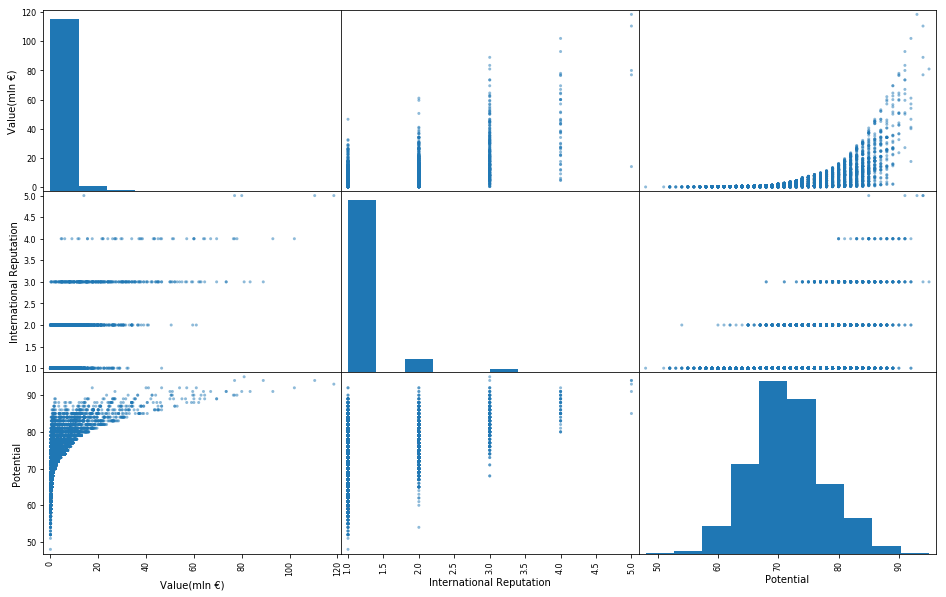

In [53]:
from pandas.plotting import scatter_matrix
scatter_matrix(footballers[attributes], figsize=(16, 10))

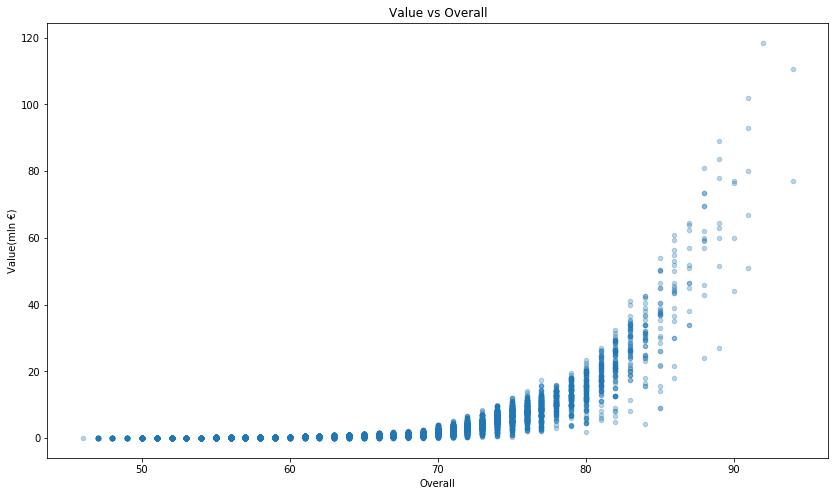

In [54]:
footballers.plot(kind="scatter", x="Overall", y="Value(mln €)", alpha=0.3, figsize=(14, 8), title='Value vs Overall')

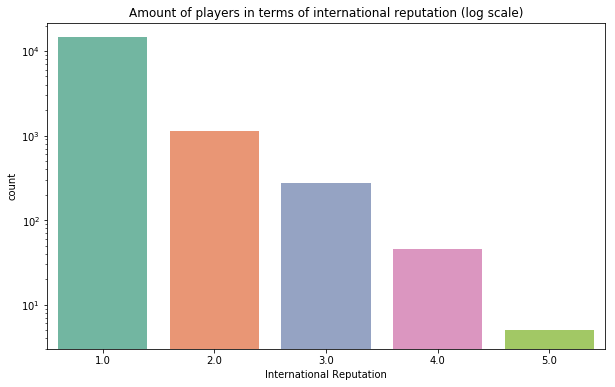

In [55]:
plt.figure(figsize=(10,6))
plt.yscale('log')
plt.title('Amount of players in terms of international reputation (log scale)')
sns.countplot(footballers['International Reputation'], palette="Set2")

<p style="text-align:center;"><b>Less important data, but showing interesting information.</b></p>

Forwards (1) have a better finish than defenders (0) and midfielders (2).

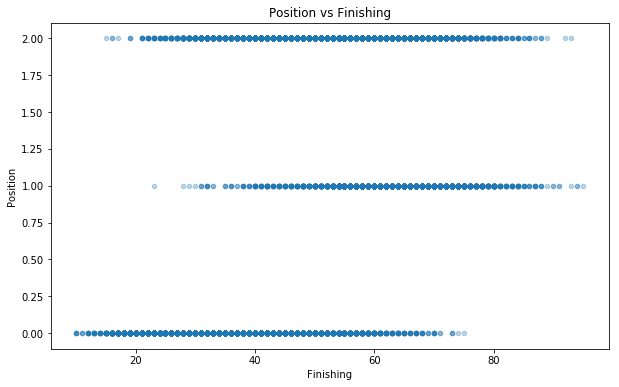

In [56]:
footballers.plot(kind="scatter", x="Finishing", y="Position", alpha=0.3, figsize=(10, 6), title='Position vs Finishing')

If higher player, the more accurate head play.

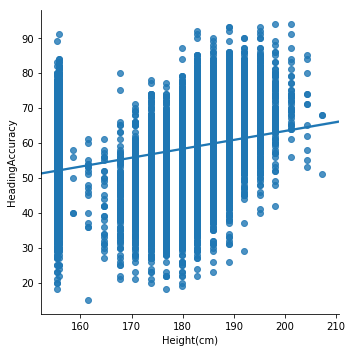

In [57]:
sns.lmplot(x="Height(cm)", y="HeadingAccuracy", data=footballers)

<h1>Data standardization</h1>

In [54]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

<b>I scale the entire data set except labels.</b>

In [55]:
scaler.fit(footballers.drop('Value(mln €)',axis=1))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [56]:
scaled_features = scaler.transform(footballers.drop('Value(mln €)',axis=1))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [57]:
df_features = pd.DataFrame(data=scaled_features, columns=footballers.columns[1:])
df_features.insert(0, "Value(mln €)", footballers['Value(mln €)'], True)

In [58]:
df_features.head()

,Value(mln €),Wage(thous €),Age,Overall,Potential,Preferred Foot Right,Special,Work Rate Attack,Work Rate Deffense,Body Type,...,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Marking,StandingTackle,SlidingTackle
0,110.5,24.530842,1.324826,4.048091,3.696692,-1.739702,2.719488,-0.449586,-0.181985,0.810449,...,2.708212,-0.801935,-1.510505,2.670851,2.986840,1.831046,3.517184,-1.062194,-1.246042,-1.230946
1,77.0,17.455796,1.765227,4.048091,3.696692,0.574811,2.851710,1.378271,-2.060492,0.810449,...,2.644572,0.237534,-1.138157,2.739067,2.056095,2.631165,3.418550,-1.352905,-1.089501,-1.387481
2,118.5,12.370607,0.223825,3.754270,3.532228,0.574811,2.419446,1.378271,-0.181985,-0.823072,...,1.944532,-0.247552,-0.765809,2.329772,2.443905,2.311117,3.319916,-1.411047,-1.454763,-0.865699
3,102.0,15.244844,0.444025,3.607359,3.367763,0.574811,3.121239,1.378271,1.696522,0.810449,...,2.517292,1.138407,0.564004,2.193341,2.986840,2.151093,2.728114,0.972784,0.319366,0.073509
4,93.0,14.581559,0.444025,3.607359,3.203299,0.574811,2.414361,1.378271,-0.181985,0.810449,...,1.817252,-0.386148,-0.499847,2.193341,2.599029,2.711177,3.024015,-1.004052,-1.298222,-1.439659


<b>I save the prepared data set to a file.</b>

In [59]:
pd.DataFrame.to_csv(df_features, "final_data.csv")

<h3 style="text-align:center;"><b>In the second file I will be testing different regression models and then try to tune the best of them.</b></h3>